# **LTFS Data Science FinHack 2**

## **Problem statement**

LTFS receives a lot of requests for its various finance offerings that include housing loan, two-wheeler loan, real estate financing and micro loans. The number of applications received is something that varies a lot with season. Going through these applications is a manual process and is tedious. Accurately forecasting the number of cases received can help with resource and manpower management resulting into quick response on applications and more efficient processing.

We have been appointed with the task of forecasting daily cases for **next 3 months for 2 different business segments** at the **country level** keeping in consideration the following major Indian festivals (inclusive but not exhaustive list): Diwali, Dussehra, Ganesh Chaturthi, Navratri, Holi etc. (We are free to use any publicly available open source external datasets). Some other examples could be:

 + Weather
 + Macroeconomic variables

we also note that the external dataset must belong to a reliable source.

## **Data Dictionary**

The train data has been provided in the following way:

 + For business segment 1, historical data has been made available at branch ID level
 + For business segment 2, historical data has been made available at State level.
 

## **Train File**

|Variable|	Definition|
|:------:|:----------:|
|application_date|Date of application|
|application_date|	Date of application|
|segment|	Business Segment (1/2)|
|branch_id|	Anonymised id for branch at which application was received|
|state|	State in which application was received (Karnataka, MP etc.)|
|zone|	Zone of state in which application was received (Central, East etc.)|
|case_count|	(Target) Number of cases/applications received|

## **Test File**

Forecasting needs to be done at country level for the dates provided in test set for each segment.

|Variable|	Definition|
|:------:|:----------:|
|id|	Unique id for each sample in test set|
|application_date|	Date of application|
| segment|	Business Segment (1/2)|

## **Evaluation**

**Evaluation Metric**

The evaluation metric for scoring the forecasts is MAPE (Mean Absolute Percentage Error) M with the formula:

$$M = \frac{100}{n}\sum_{t = 1}^{n}|\frac{A_t - F_t}{A_t}|$$
 
Where $A_t$ is the actual value and $F_t$ is the forecast value.


The Final score is calculated using $MAPE$ for both the segments using the formula:

$Final Score = 0.5*MAPE_{Segment1} + 0.5*MAPE_{Segment2}$


## **Getting started**

### **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### **Reading data**

In [2]:
# Setting the path
import os
path = "E:/Data Science/LTFS-Data-Science-FinHack-2"
os.chdir(path)

In [3]:
# Importing the dataset
train = pd.read_csv("./Input/train_fwYjLYX.csv")
test = pd.read_csv("./Input/test_1eLl9Yf.csv")
Sample_submission = pd.read_csv("./Input/sample_submission_IIzFVsf.csv")

## **Data Preprocessing**

In [4]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.00,WEST BENGAL,EAST,40.00
1,2017-04-03,1,1.00,WEST BENGAL,EAST,5.00
2,2017-04-04,1,1.00,WEST BENGAL,EAST,4.00
3,2017-04-05,1,1.00,WEST BENGAL,EAST,113.00
4,2017-04-07,1,1.00,WEST BENGAL,EAST,76.00


In [5]:
# Data preprocessing function
train_v2 = pd.DataFrame(train.groupby(['application_date', 'segment'])['case_count'].sum()).reset_index()
train_v2.head()

,application_date,segment,case_count
0,2017-04-01,1,299.00
1,2017-04-01,2,897.00
2,2017-04-02,2,605.00
3,2017-04-03,1,42.00
4,2017-04-03,2,2016.00


## **Feature engineering**

In [6]:
def feature_eng(train_v2):
    train_v2['application_date'] = pd.to_datetime(train_v2['application_date'])
    train_v2['year'] = train_v2['application_date'].dt.year
    train_v2['Month'] = train_v2['application_date'].dt.month
    train_v2['Date'] = train_v2['application_date'].dt.day
    train_v2['weekday'] = train_v2['application_date'].dt.weekday_name

    Seasons = {6: 'Monsoon', 7: 'Monsoon', 8: 'Monsoon', 9: 'Monsoon',
               10: 'Winter', 11: 'Winter', 12: 'Winter', 1: 'Winter',
               2: 'Summer', 3: 'Summer', 4: 'Summer', 5: 'Summer'}
  
    train_v2['Seasons'] = train_v2['Month'].map(Seasons)

    train_v2['segment'] = np.where(train_v2['segment'] == 1, 1, 0)

    dummy_col = ['weekday', 'Seasons']
    temp = train_v2[dummy_col]
    temp = pd.get_dummies(temp)

    train_v2 = train_v2.drop(dummy_col, axis = 1)
    train_v2 = pd.concat([train_v2, temp], axis = 1)

    train_v2 = train_v2.drop(['application_date'], axis = 1)
  
    return train_v2

## **Machine Learning**

### **Creating X and y**

In [7]:
X = train_v2.drop(['case_count'], axis = 1)
y = np.log(train_v2['case_count'])

X = feature_eng(X)

print("Shape of features :", X.shape)
print("Shape of labels :", y.shape)

X.head()

Shape of features : (1650, 14)
Shape of labels : (1650,)


,segment,year,Month,Date,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,Seasons_Monsoon,Seasons_Summer,Seasons_Winter
0,1,2017,4,1,0,0,1,0,0,0,0,0,1,0
1,0,2017,4,1,0,0,1,0,0,0,0,0,1,0
2,0,2017,4,2,0,0,0,1,0,0,0,0,1,0
3,1,2017,4,3,0,1,0,0,0,0,0,0,1,0
4,0,2017,4,3,0,1,0,0,0,0,0,0,1,0


### **Splitting data into train, validation and test**

In [8]:
# Dividing data into train and validation set
from sklearn.model_selection import train_test_split

validation_percent = 0.30
test_percent = 0.50
seed = 786

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = validation_percent, random_state = seed)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size = test_percent, random_state = seed)

# Shape of data
print("Number of rows and columns in train dataset:",X_train.shape)
print("Number of rows and columns in validation dataset:",X_validation.shape)
print("Number of rows and columns in test dataset:",X_test.shape)

print("Number of rows and columns in target variable for training:",y_train.shape)
print("Number of rows and columns in target variable for validation:",y_validation.shape)
print("Number of rows and columns in target variable for test:",y_test.shape)

Number of rows and columns in train dataset: (1155, 14)
Number of rows and columns in validation dataset: (247, 14)
Number of rows and columns in test dataset: (248, 14)
Number of rows and columns in target variable for training: (1155,)
Number of rows and columns in target variable for validation: (247,)
Number of rows and columns in target variable for test: (248,)


### **Model evualuation**

In [9]:
import sklearn.metrics as sklm
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, PassiveAggressiveRegressor, Perceptron
from sklearn.neighbors import KNeighborsRegressor, NearestCentroid
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor 
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [10]:
def mape(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    return mape

In [11]:
def accuracy_summary(Regressor, x_train, y_train, x_validation, y_validation):
    t0 = time()
    model = Regressor.fit(x_train, y_train)
    y_pred = model.predict(x_validation)
    train_test_time = time() - t0
    #accuracy = r2_score(y_validation, y_pred)
    accuracy = mape(y_pred, y_validation)
    return accuracy, train_test_time

In [12]:
seed = 123
names = ["Linear Regression", "SGDRegressor", "Linear SVR", "Lasso","Ridge", "Passive-Aggresive",
        "DecisionTreeRegressor","RandomForestRegressor","AdaBoostRegressor", "GradientBoostingRegressor", "XGBRegressor"]

Regressors = [
    LinearRegression(),
    SGDRegressor(random_state=seed),
    LinearSVR(random_state=seed),
    #SVR(),
    Lasso(random_state=seed),
    Ridge(random_state=seed),
    PassiveAggressiveRegressor(random_state=seed),
    DecisionTreeRegressor(random_state=seed),
    RandomForestRegressor(random_state=seed, n_estimators=500),
    AdaBoostRegressor(random_state=seed, n_estimators=500),
    GradientBoostingRegressor(random_state=seed, n_estimators=500),
    XGBRegressor(n_estimators=500, random_state=seed)
    ]

zipped_reg = zip(names,Regressors)

def Regressor_comparator(Regressor=zipped_reg):
    result = []
    for n,c in Regressor:
        checker_pipeline = Pipeline([
            ('Regressor', c)
        ])
        print("Validation result for {}".format(n))
        print (c)
        reg_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_validation, y_validation)
        result.append((n,reg_accuracy,tt_time))
    return result

In [13]:
Regression_result = Regressor_comparator()
Regression_result

Validation result for Linear Regression
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Validation result for SGDRegressor
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=123,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Validation result for Linear SVR
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=123, tol=0.0001, verbose=0)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Validation result for Lasso
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False)
Validation result for Ridge
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)
Validation result for Passive-Aggresive
PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=123, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False)
Validation result for DecisionTreeRegressor
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_dec

[('Linear Regression', 0.10513573449395285, 1.5108850002288818),
 ('SGDRegressor', 60169262908319.36, 0.1201634407043457),
 ('Linear SVR', 0.3326559027917069, 0.19734454154968262),
 ('Lasso', 0.15777142146560802, 0.15746665000915527),
 ('Ridge', 0.10512046272408691, 0.32485342025756836),
 ('Passive-Aggresive', 0.17484383055544325, 0.012978076934814453),
 ('DecisionTreeRegressor', 0.08117820373237314, 0.07620477676391602),
 ('RandomForestRegressor', 0.05420337132096428, 2.7282321453094482),
 ('AdaBoostRegressor', 0.09231015135427076, 0.13871502876281738),
 ('GradientBoostingRegressor', 0.07042529886880469, 0.7022268772125244),
 ('XGBRegressor', 0.07042746358188312, 0.7274079322814941)]

In [14]:
Regression_result_df = pd.DataFrame(Regression_result)
Regression_result_df.columns = ['Regressor', 'R2-Score', 'Train and test time']
Regression_result_df.sort_values(by='R2-Score', ascending=False)
Regression_result_df['R2-Score'] = (Regression_result_df['R2-Score']*100).round(1).astype(str) + '%'
Regression_result_df

,Regressor,R2-Score,Train and test time
0,Linear Regression,10.5%,1.51
1,SGDRegressor,6016926290831936.0%,0.12
2,Linear SVR,33.3%,0.20
3,Lasso,15.8%,0.16
4,Ridge,10.5%,0.32
5,Passive-Aggresive,17.5%,0.01
6,DecisionTreeRegressor,8.1%,0.08
7,RandomForestRegressor,5.4%,2.73
8,AdaBoostRegressor,9.2%,0.14
9,GradientBoostingRegressor,7.0%,0.70


### **Tuning Randomforest model**

In [15]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

model = model.fit(X_train, y_train)
y_predict_validation = model.predict(X_validation)

In [16]:
import math
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    MAPE = mape(y_predicted, y_true)
    # r2_adj = r2 - (y_true.shape[0] - 1)/(y_true.shape[0] - n_parameters - 1) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('MAPE                    = ' + str(MAPE))
    
    # print('Adjusted R^2           = ' + str(r2_adj))

print_metrics(y_validation, y_predict_validation)

Mean Square Error      = 0.3008800222513618
Root Mean Square Error = 0.5485253159621366
Mean Absolute Error    = 0.28422202650153067
Median Absolute Error  = 0.12658874394035635
R^2                    = 0.8364501577346957
MAPE                    = 0.05420337132096428


In [17]:
import numpy.random as nr
import sklearn.model_selection as ms

nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

In [18]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_estimator_.n_estimators)

300


Performance metrics by parameter
Parameter   Mean performance   STD performance
  100.00        0.76199            0.06711
  200.00        0.76506            0.06485
  300.00        0.76554            0.06590
  400.00        0.76404            0.06670
  500.00        0.76447            0.06643
  600.00        0.76399            0.06707
  700.00        0.76375            0.06682
  800.00        0.76395            0.06681
  900.00        0.76339            0.06685
 1000.00        0.76325            0.06685


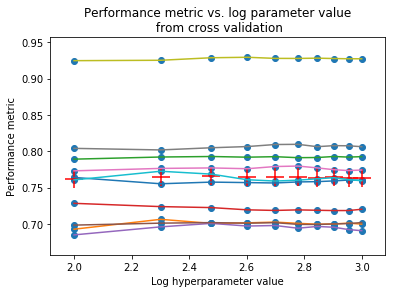

In [19]:
def plot_cv(clf, params_grid, param = 'n_estimators'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)

In [20]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_estimator_.max_features)

9


Performance metrics by parameter
Parameter   Mean performance   STD performance
    1.00        0.63151            0.08791
    2.00        0.67552            0.09155
    3.00        0.71727            0.09377
    4.00        0.74483            0.08558
    5.00        0.76026            0.08272
    6.00        0.76679            0.08211
    7.00        0.77052            0.07846
    8.00        0.77002            0.08081
    9.00        0.77567            0.07607
   10.00        0.77458            0.07814


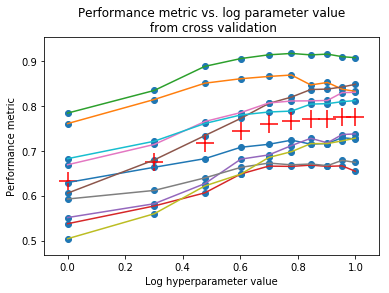

In [21]:
def plot_cv(clf, params_grid, param = 'max_features'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)

In [22]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10]}

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_estimator_.min_samples_split)

3


Performance metrics by parameter
Parameter   Mean performance   STD performance
    2.00        0.77567            0.07607
    3.00        0.77852            0.07420
    4.00        0.77607            0.07522
    5.00        0.77591            0.07667
    6.00        0.77480            0.07698
    7.00        0.77278            0.07643
    8.00        0.77249            0.07646
    9.00        0.77356            0.07673
   10.00        0.77313            0.07730


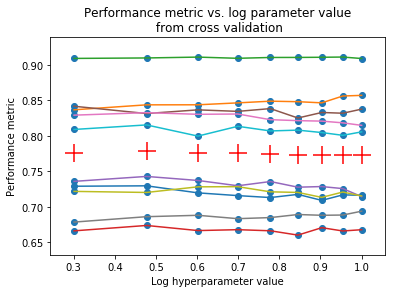

In [24]:
def plot_cv(clf, params_grid, param = 'min_samples_split'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)

In [25]:
nr.seed(786)
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

cv_estimate = ms.cross_val_score(model, X_train, y_train, scoring = 'r2',
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.779
SDT of the metric       = 0.074
Outcomes by cv fold
Fold  1    0.730
Fold  2    0.844
Fold  3    0.910
Fold  4    0.674
Fold  5    0.743
Fold  6    0.831
Fold  7    0.833
Fold  8    0.686
Fold  9    0.720
Fold 10    0.815


In [30]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_estimator_.min_samples_leaf)

2


Performance metrics by parameter
Parameter   Mean performance   STD performance
    1.00        0.77567            0.07607
    2.00        0.77962            0.07793
    3.00        0.77699            0.07959
    4.00        0.77168            0.08008
    5.00        0.76592            0.08178
    6.00        0.76217            0.08183
    7.00        0.75647            0.08305
    8.00        0.75169            0.08324
    9.00        0.74911            0.08389
   10.00        0.74472            0.08347


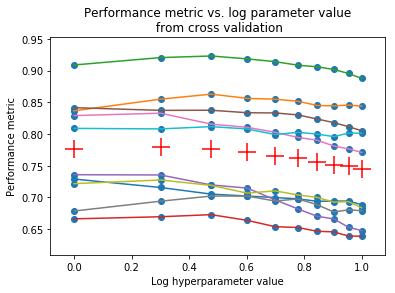

In [31]:
def plot_cv(clf, params_grid, param = 'min_samples_leaf'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)

In [32]:
nr.seed(786)
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

cv_estimate = ms.cross_val_score(model, X_train, y_train, scoring = 'r2',
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.780
SDT of the metric       = 0.078
Outcomes by cv fold
Fold  1    0.716
Fold  2    0.855
Fold  3    0.921
Fold  4    0.670
Fold  5    0.735
Fold  6    0.837
Fold  7    0.833
Fold  8    0.694
Fold  9    0.727
Fold 10    0.808


In [37]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_estimator_.max_depth)

20


Performance metrics by parameter
Parameter   Mean performance   STD performance
   10.00        0.77278            0.07702
   20.00        0.77631            0.07691
   30.00        0.77567            0.07607
   40.00        0.77567            0.07607
   50.00        0.77567            0.07607
   60.00        0.77567            0.07607
   70.00        0.77567            0.07607
   80.00        0.77567            0.07607
   90.00        0.77567            0.07607
  100.00        0.77567            0.07607


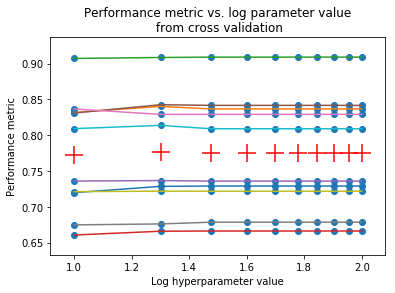

In [38]:
def plot_cv(clf, params_grid, param = 'max_depth'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)

In [39]:
nr.seed(786)
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

cv_estimate = ms.cross_val_score(model, X_train, y_train, scoring = 'r2',
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.780
SDT of the metric       = 0.078
Outcomes by cv fold
Fold  1    0.715
Fold  2    0.855
Fold  3    0.920
Fold  4    0.670
Fold  5    0.735
Fold  6    0.837
Fold  7    0.833
Fold  8    0.695
Fold  9    0.727
Fold 10    0.808


In [43]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"bootstrap": [True, False]}

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_estimator_.bootstrap)

True


In [45]:
nr.seed(999)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"criterion": ["mse", "mae"]}

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_estimator_.criterion)

mse


In [46]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

model = model.fit(X_train, y_train)
y_predict_validation = model.predict(X_validation)

In [47]:
import math
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    MAPE = mape(y_predicted, y_true)
    # r2_adj = r2 - (y_true.shape[0] - 1)/(y_true.shape[0] - n_parameters - 1) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('MAPE                    = ' + str(MAPE))
    
    # print('Adjusted R^2           = ' + str(r2_adj))

print_metrics(y_validation, y_predict_validation)

Mean Square Error      = 0.30734396853130436
Root Mean Square Error = 0.5543861186315043
Mean Absolute Error    = 0.28856289073946356
Median Absolute Error  = 0.142583798616295
R^2                    = 0.8329365399591265
MAPE                    = 0.05665148297673893


In [48]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features= 9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)
model = model.fit(X_train, y_train)

In [49]:
y_predict_test = model.predict(X_test)
print_metrics(y_test, y_predict_test)

Mean Square Error      = 0.5712347277531424
Root Mean Square Error = 0.7558007196034828
Mean Absolute Error    = 0.3314741465101353
Median Absolute Error  = 0.13326187611430118
R^2                    = 0.7258537081150298
MAPE                    = 0.07654029874514395


## **Predicting test data**

In [50]:
test_v2 = test.drop(['id'], axis = 1)
test_v2 = feature_eng(test_v2)

print("Shape of features :", test_v2.shape)

Shape of features : (180, 13)


In [51]:
feature_list = X.columns.tolist()
dummy_add = list(set(feature_list) - set(test_v2.columns))

for newcol in dummy_add:
    test_v2[newcol] = 0

test_v2 = test_v2[feature_list]
test_v2.head()

,segment,year,Month,Date,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,Seasons_Monsoon,Seasons_Summer,Seasons_Winter
0,1,2019,7,6,0,0,1,0,0,0,0,1,0,0
1,1,2019,7,7,0,0,0,1,0,0,0,1,0,0
2,1,2019,7,8,0,1,0,0,0,0,0,1,0,0
3,1,2019,7,9,0,0,0,0,0,1,0,1,0,0
4,1,2019,7,10,0,0,0,0,0,0,1,1,0,0


In [52]:
test['case_count'] = np.exp(model.predict(test_v2))
test['case_count'] = test['case_count'].round(0)
test.head()

,id,application_date,segment,case_count
0,1,2019-07-06,1,2256.00
1,2,2019-07-07,1,1308.00
2,3,2019-07-08,1,3278.00
3,4,2019-07-09,1,3196.00
4,5,2019-07-10,1,3445.00


In [53]:
Submission = test[['id', 'application_date', 'segment', 'case_count']]

Submission.to_csv("./Output/Submission_v4.csv", index = False)